## Co-moving stars in Kepler

(done in a very hacky way) (but this is probably ok because we're assuming all the stars are far away)

In [1]:
import numpy as np
from astropy.table import Table, unique
from astropy import units as u
import astropy.coordinates as coord
from astropy.time import Time
from astropy.io import fits
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

Load up the table of all Gaia DR2 sources within the Kepler field:

In [2]:
gaia_table_file = '../data/gaia-kepler-dustin.fits'
hdul = fits.open(gaia_table_file)
gaia_src_tbl = Table(hdul[1].data)

In [3]:
#filter = (gaia_src_tbl['phot_g_mean_mag'] >= 18.) & (gaia_src_tbl['parallax'] > 0.01)
#gaia_src_tbl = gaia_src_tbl[filter]

In [4]:
gaia_src_tbl = gaia_src_tbl.to_pandas()

Now load up the Gaia-Kepler cross-match so we can add Kepler IDs to the best-match Gaia sources:

In [5]:
kepler_table_file = '../data/kepler_dr2_1arcsec.fits'
hdul = fits.open(kepler_table_file)
kepler_tbl = Table(hdul[1].data)
gaia_kepler_matches = kepler_tbl['kepid', 'kepler_gaia_ang_dist', 'source_id', 'nconfp', 'nkoi', 'planet?']
gaia_kepler_matches = gaia_kepler_matches.to_pandas()
print(len(gaia_kepler_matches))

195830


Trim off the less-good matches so that there's one unique Gaia source per Kepler target:

In [6]:
gaia_kepler_matches.sort_values(['kepid', 'kepler_gaia_ang_dist'], inplace=True)
gaia_kepler_matches.drop_duplicates('kepid', inplace=True)
print(len(gaia_kepler_matches))

193244


And join the tables:

In [7]:
table = gaia_src_tbl.merge(gaia_kepler_matches, on='source_id', how='left')
len(table)

9376693

In [8]:
test_id = 2105885485289168768
print(gaia_kepler_matches[gaia_kepler_matches['source_id'] == test_id])
print(gaia_src_tbl[gaia_src_tbl['source_id'] == test_id])

          kepid  kepler_gaia_ang_dist            source_id  nconfp  nkoi  \
100000  8151284              0.108671  2105885485289168768       0     0   

       planet?  
100000    none  
                solution_id                   designation  \
979714  1635721458409799680  Gaia DR2 2105885485289168768   

                  source_id  random_index  ref_epoch          ra  ra_error  \
979714  2105885485289168768     486039161     2015.5  285.685012  0.018974   

              dec  dec_error  parallax          ...           e_bp_min_rp_val  \
979714  44.060521   0.020247  0.654823          ...                    0.1898   

        e_bp_min_rp_percentile_lower  e_bp_min_rp_percentile_upper  \
979714                        0.1285                        0.2864   

        flame_flags  radius_val  radius_percentile_lower  \
979714         3503    1.370843                  1.27356   

        radius_percentile_upper  lum_val  lum_percentile_lower  \
979714                 1.658074   2.3351  

Now load up Dustin's pairs:

In [9]:
pairs_file = '../data/matched-pairs-dustin.fits'
hdul = fits.open(pairs_file)
pairs = hdul[0].data

Define some useful functions:

In [11]:
def ppm_check(star1, star2, sigma=5.):
    """
    Returns True if the differences between parallax, pmra, and pmdec are all below 
    the sigma threshold.
    """
    names = ['parallax', 'pmra', 'pmdec']
    for name in names:
        err = np.sqrt(star1[name+'_error']**2 + star2[name+'_error']**2)
        if np.isnan(star1[name]) or np.isnan(star2[name]) or np.isnan(err):
            return False
        if (np.abs(star1[name] - star2[name])/err) >= sigma:
            return False
    return True

In [12]:
def make_x(star):
    """
    returns a vector of x = [parallax, pmra, pmdec]
    """
    names = ['parallax', 'pmra', 'pmdec']
    return np.array([star[n] for n in names])

def make_cov(star):
    """
    returns covariance matrix C corresponding to x
    """
    names = ['parallax', 'pmra', 'pmdec']
    C = np.zeros((3, 3)) # brittle
    for i, name1 in enumerate(names):
        err = star[name1+'_error']
        C[i, i] = err ** 2
        for j, name2 in enumerate(names):
            if j >= i:
                continue
            corr = star["{0}_{1}_corr".format(name2, name1)]
            C[i, j] = corr * np.sqrt(C[i, i] * C[j, j])
            C[j, i] = C[i, j]
    return C

def chisq(star1, star2):
    """
    calculates chisquared for two stars based on their parallax and 2D proper motions
    """
    deltax = make_x(star1) - make_x(star2)
    cplusc = make_cov(star1) + make_cov(star2)
    return np.dot(deltax, np.linalg.solve(cplusc, deltax))

In [13]:
def check_with_primary(m, primary):
    if ppm_check(primary, m):
        return chisq(primary, m)
    else:
        return -1

Now calculate a goodness-of-fit metric for each pair, skipping over the ones that don't make an initial cut:

In [14]:
chisqs = np.zeros_like(pairs) - 1.

for i,row in tqdm(enumerate(pairs)):
    primary = table.iloc[i]
    matches = table.iloc[row[(row > -1) & (row > i)]] # ignore non-matches and duplicates
    if len(matches) > 0:
        row_of_chisqs = matches.apply(check_with_primary, args=(primary,), axis=1)
        chisqs[i,:len(row_of_chisqs)] = row_of_chisqs.values

9376683it [2:47:27, 933.20it/s]


Save the outputs and take a look at their distribution:

In [18]:
hdu = fits.PrimaryHDU(chisqs)
hdulist = fits.HDUList([hdu])
hdulist.writeto('../data/chisqs_matched-pairs-dustin.fits')
hdulist.close()

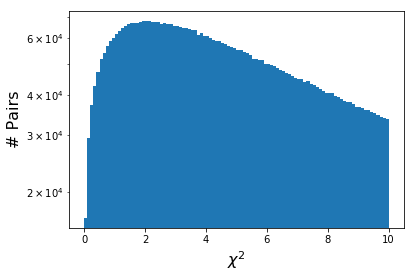

In [17]:
plt.hist(chisqs[(chisqs > 0.) & (chisqs < 10.)], bins=100)
plt.xlabel('$\chi^2$', fontsize=16)
plt.ylabel('# Pairs', fontsize=16)
plt.yscale('log')
plt.savefig('chisq_keplerpairs.png')

OK, now let's select the best-fit pairs and save their indicies for easy access:

In [69]:
matches_mask = (chisqs > 0) & (chisqs < 2)
np.sum(matches_mask)

1112369

In [34]:
len_inds, len_matches = np.shape(pairs)
pairs_inds = np.array([np.arange(len_inds),]*len_matches).transpose()
pairs_ind1s = pairs_inds[matches_mask]
pairs_ind2s = pairs[matches_mask]

In [20]:
def read_match_attr(ind1, ind2, attr):
    return table.iloc[ind1][attr], table.iloc[ind2][attr]

In [39]:
print("source_ids of a pair:")
print(read_match_attr(pairs_ind1s[0], pairs_ind2s[0], 'source_id'))

source_ids of a pair:
(2097438792153786368, 2097438727722672128)


Sanity check: plot the parallax and proper motions of an identified match

In [210]:
from plot_tools import error_ellipse
fs = 12

In [204]:
def plot_xs(i, sigma=1):
    x1 = make_x(table.iloc[pairs_ind1s[i]])
    cov1 = make_cov(table.iloc[pairs_ind1s[i]])
    x2 = make_x(table.iloc[pairs_ind2s[i]])
    cov2 = make_cov(table.iloc[pairs_ind2s[i]])
    fig = plt.figure(figsize=(12,4))
    ax1 = fig.add_subplot(131)
    error_ellipse(ax1, x1[0], x1[1], cov1[:2,:2], ec='red', sigma=sigma)
    error_ellipse(ax1, x2[0], x2[1], cov2[:2,:2], ec='blue', sigma=sigma)
    ax1.set_xlim([min([x1[0], x2[0]]) - 5., max([x1[0], x2[0]]) + 5.])
    ax1.set_ylim([min([x1[1], x2[1]]) - 5., max([x1[1], x2[1]]) + 5.])
    ax1.set_xlabel('Parallax (mas)', fontsize=fs)
    ax1.set_ylabel('PM RA (mas yr$^{-1}$)', fontsize=fs)

    ax2 = fig.add_subplot(133)
    error_ellipse(ax2, x1[1], x1[2], cov1[1:,1:], ec='red', sigma=sigma)
    error_ellipse(ax2, x2[1], x2[2], cov2[1:,1:], ec='blue', sigma=sigma)
    ax2.set_xlim([min([x1[1], x2[1]]) - 5., max([x1[1], x2[1]]) + 5.])
    ax2.set_ylim([min([x1[2], x2[2]]) - 5., max([x1[2], x2[2]]) + 5.])
    ax2.set_xlabel('PM RA (mas yr$^{-1}$)', fontsize=fs)
    ax2.set_ylabel('PM Dec (mas yr$^{-1}$)', fontsize=fs)
    
    ax3 = fig.add_subplot(132)
    c1 = np.delete(np.delete(cov1, 1, axis=0), 1, axis=1)
    c2 = np.delete(np.delete(cov2, 1, axis=0), 1, axis=1)
    error_ellipse(ax3, x1[0], x1[2], c1, ec='red', sigma=sigma)
    error_ellipse(ax3, x2[0], x2[2], c2, ec='blue', sigma=sigma)
    ax3.set_xlim([min([x1[0], x2[0]]) - 5., max([x1[0], x2[0]]) + 5.])
    ax3.set_ylim([min([x1[2], x2[2]]) - 5., max([x1[2], x2[2]]) + 5.])
    ax3.set_xlabel('Parallax (mas)', fontsize=fs)
    ax3.set_ylabel('PM Dec (mas yr$^{-1}$)', fontsize=fs)
    
    fig.subplots_adjust(wspace = 0.5)
    fig.text(0.5, 0.95, 'match #{0}'.format(i), horizontalalignment='center', 
             transform=ax.transAxes, fontsize=fs+2)

match 849000: source_ids (2078461702490729600, 2078462978098136448)


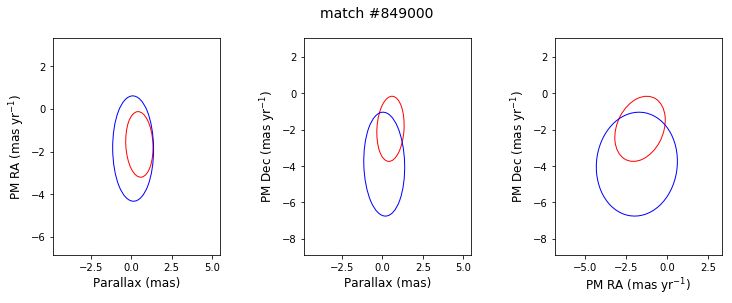

In [209]:
i = np.random.randint(0, len(pairs_ind1s))
print("match {0}: source_ids {1}".format(i, 
            read_match_attr(pairs_ind1s[i], pairs_ind2s[i], 'source_id')))
plot_xs(i, sigma=3)

Let's look at the relative luminosities of each match:

In [214]:
(gmag1, gmag2) = read_match_attr(pairs_ind1s, pairs_ind2s, 'phot_g_mean_mag')
(plx1, plx2) = read_match_attr(pairs_ind1s, pairs_ind2s, 'parallax')
dist1 = 1.e3/plx1
absg1 = gmag1 - 5.*(np.log10(dist1) - 1.)
dist2 = 1.e3/plx2
absg2 = gmag2 - 5.*(np.log10(dist2) - 1.)

/Users/mbedell/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/Users/mbedell/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


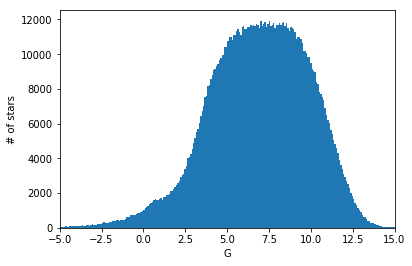

In [273]:
mask = np.all(np.vstack([np.isfinite(absg1), np.isfinite(absg2)]), axis=0)
absg = np.append(absg1[mask], absg2[mask])
hist = plt.hist(absg, bins=500)
plt.xlim([-5,15])
plt.xlabel('G')
plt.ylabel('# of stars')
plt.savefig('absmag_hist.png')

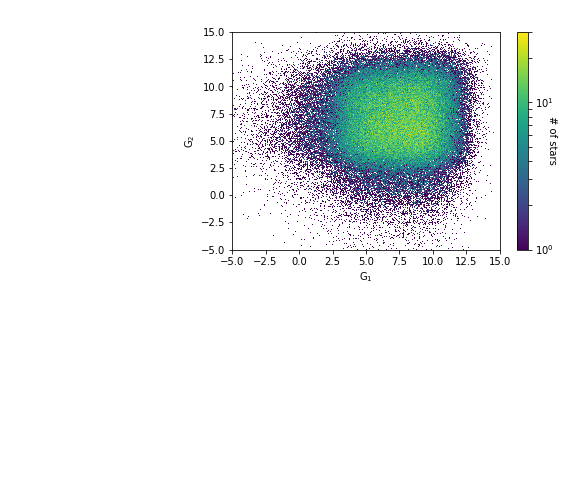

In [274]:
from matplotlib.colors import LogNorm
plt.hist2d(absg1[mask], absg2[mask], bins=(1000,1000), norm=LogNorm())
cbar = plt.colorbar()
cbar.ax.set_ylabel('# of stars', rotation=270)
plt.xlabel('G$_{1}$')
plt.ylabel('G$_{2}$')
plt.xlim([-5, 15])
plt.ylim([-5, 15])
plt.savefig('absmag_pairs.pdf')

Now let's see how many of the matches are in the Kepler catalog, and whether any of them have planets!

In [207]:
ind1_is_kic = np.isfinite(table.iloc[pairs_ind1s]['kepid'])
ind2_is_kic = np.isfinite(table.iloc[pairs_ind2s]['kepid'])

In [59]:
one_is_kic = np.any(np.vstack([ind1_is_kic, ind2_is_kic]), axis=0)
both_are_kic = np.all(np.vstack([ind1_is_kic, ind2_is_kic]), axis=0)

In [73]:
np.sum(both_are_kic)

137

In [74]:
for i1, i2 in zip(pairs_ind1s[both_are_kic], pairs_ind2s[both_are_kic]):
    print(read_match_attr(i1,i2,'planet?'))

('none', 'none')
('none', 'none')
('none', 'none')
('none', 'none')
('none', 'none')
('none', 'none')
('none', 'none')
('none', 'none')
('none', 'none')
('none', 'none')
('none', 'cand')
('none', 'none')
('none', 'none')
('none', 'none')
('none', 'cand')
('none', 'none')
('none', 'none')
('none', 'none')
('none', 'none')
('none', 'none')
('none', 'none')
('none', 'none')
('none', 'none')
('none', 'none')
('none', 'none')
('none', 'none')
('none', 'none')
('cand', 'cand')
('none', 'none')
('none', 'none')
('none', 'none')
('none', 'cand')
('none', 'none')
('none', 'none')
('none', 'none')
('none', 'cand')
('none', 'none')
('none', 'none')
('none', 'none')
('none', 'none')
('none', 'none')
('none', 'none')
('none', 'none')
('none', 'none')
('none', 'none')
('none', 'none')
('none', 'none')
('none', 'none')
('none', 'none')
('none', 'cand')
('conf', 'none')
('none', 'none')
('none', 'none')
('none', 'none')
('none', 'none')
('none', 'none')
('none', 'none')
('cand', 'none')
('none', 'none